# Run Analysis

This notebook analyze the information generated by the experiments.

In [17]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [21]:
plt.style.use('ggplot')

In [22]:
experiment = '28-06-2022--22-13-20'
with open(f'experiment_info/{experiment}/run_info.json', 'r') as file:
    run_info = json.load(file)

pprint(run_info)

{'Avg. len of series': 140.71428571428572,
 'config input': {'dataset': {'file name': 'm3_monthly_dataset.json',
                              'file path': 'datasets/m3_monthly_dataset.json',
                              'file type': 'json',
                              'min length': 130,
                              'use series': 210},
                  'execution config': {'n of workers': 20},
                  'modelling config': {'forecast horizon': 1,
                                       'score measure': 'SMAPE',
                                       'test size': 15,
                                       'validation size': 10},
                  'models': ['MLP', 'EN', 'ETS', 'LGBM'],
                  'transformation config': {'xthresholds': [0.01, 1.1, 0.2]}},
 'messages': {},
 'model hyper_params': {'EN': {'alpha': [0.1, 1, 10, 100],
                               'l1 ratio': [0.01, 0.31, 0.61, 0.91],
                               'n of lags': [1, 3, 5]},
              

In [ ]:

run_info =  {
    "run time": ["28-06-2022--22-13-20", "29-06-2022--21-28-42"], # end time is fake right now
    "config input": {
        "dataset": {
            "file name": "m3_monthly_dataset.json",
            "file type": "json",
            "file path": "datasets/m3_monthly_dataset.json",
            "use series": 210,
            "min length": 130
        },
        "transformation config": {
            "xthresholds": [0.01, 1.1, 0.2]
        },
        "modelling config": {
            "validation size": 10,
            "test size": 15,
            "forecast horizon": 1,
            "score measure": "SMAPE"
        },
        "models": ["MLP", "EN", "ETS", "LGBM"],
        "execution config": {
            "n of workers": 20
        }
    },
    "number of series used": 210,
    "Avg. len of series": 141.0,
    "model hyper_params": {
        "MLP": {
            "n of lags": [1, 3, 5],
            "strucs": [[0], [1], [3], [5], [7]],
            "max iter": [500]
        },
        "EN": {
            "n of lags": [1, 3, 5],
            "alpha": [0.1, 1, 10, 100],
            "l1 ratio": [0.01, 0.31, 0.61, 0.91]
        },
        "ETS": {
            "seasonal periods": [12],
            "trend": ["add", "mul"],
            "seasonal": ["add", "mul"],
            "damped trend": [True, False]
        },
        "LGBM": {
            "n of lags": [1, 3, 5],
            "max depth": [-1, 10, 20],
            "min split gain": [0, 3, 5],
            "importance type": ["split", "gain"]
        }
    },
    "messages": None
    }

Load agents' run information

In [23]:
agent_infos = {}
run = run_info['run time'][0]
models = run_info['config input']['models']

for m in models:

    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'

    with open(f'experiment_info/{run}/{agent_1}.json', 'r') as file:
        agent_infos[agent_1] = json.load(file)
    with open(f'experiment_info/{run}/{agent_2}.json', 'r') as file:
        agent_infos[agent_2] = json.load(file)


Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [24]:
series_ran = list(agent_infos[agent_1].keys())
n_series_ran = len(series_ran)
agent_fails = {k: [] for k in agent_infos.keys()}
series_excluded = []

for agent, plays in agent_infos.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


## Visualisation of experiment results

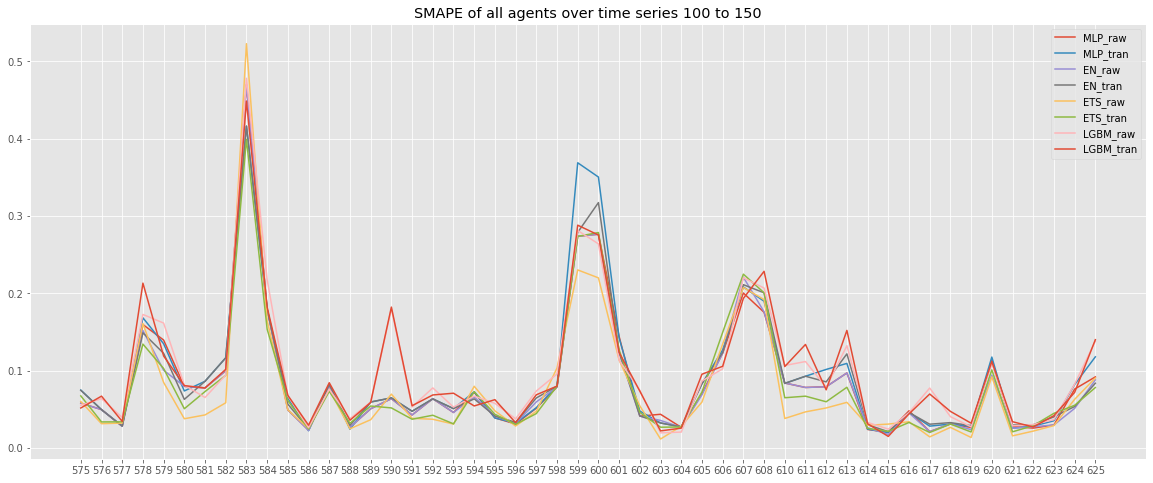

In [25]:
segment_start: int = 100
segment_end: int = 150

for agent, plays in agent_infos.items():
    plt.plot(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [play['test SMAPE'] for play in list(plays.values())[segment_start:segment_end]],
        label=f'{agent}'
    )

plt.title(f'SMAPE of all agents over time series {segment_start} to {segment_end}')
plt.legend()
plt.show()

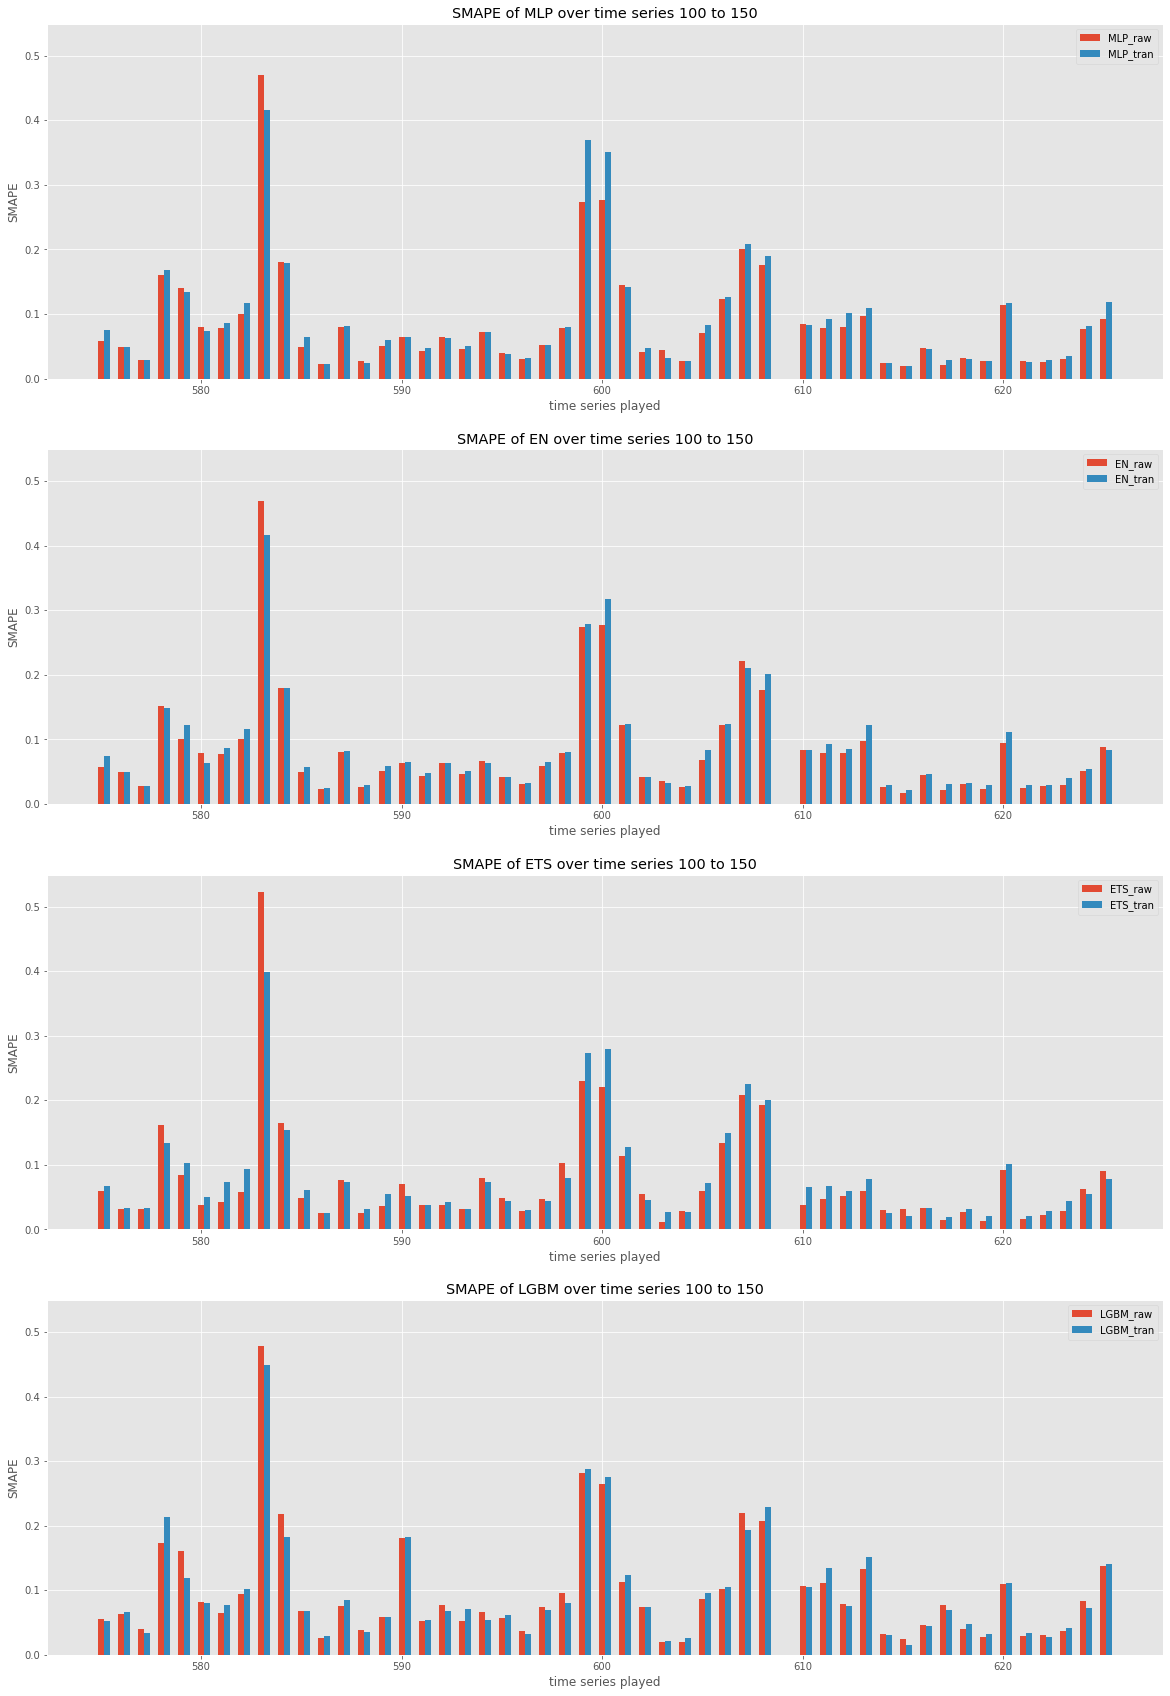

In [72]:
segment_start: int = 100
segment_end: int = 150
n_models = len(models)

fig, axs = plt.subplots(n_models, 1, sharey=True, figsize = (20, 30))
for i, m in enumerate(models):

    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [
            play['test SMAPE'] for play in list(agent_infos[agent_1].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_1
    )
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float) + 0.3,
        [
            play['test SMAPE'] for play in list(agent_infos[agent_2].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_2
    )
    axs[i].legend()
    axs[i].set_title(f'SMAPE of {m} over time series {segment_start} to {segment_end}')
    axs[i].set_xlabel('time series played')
    axs[i].set_ylabel('SMAPE')

plt.show()

### Ranking of the agents

In this section, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [27]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [28]:
ss = [5, 3, 7, 1, 10, 5]  # five scores
target = 5                # the lower the better, rank of target

lower = [1 for s in ss if s-target < 0]
rank = sum(lower) + 1
print(lower, rank)

[1, 1] 3


In [29]:
print(agent_infos['ETS_raw']['600'], agent_infos['MLP_tran']['600'])

{'message': None, 'test SMAPE': 0.21998, 'val SMAPE': 0.168834, 'best model': {'seasonal periods': 12, 'trend': 'add', 'seasonal': 'add', 'damped trend': True}, 'y hats': [2513.8768453956673, 2473.2743256216236, 3087.1496996975216, 3030.115187092799, 2893.8785157476536, 3525.833030555843, 3830.4718556359107, 2566.9024560262906, 1638.2080206303558, 1447.7384752290357, 2150.108190368312, 2466.3917384653764, 2221.215877841701, 2274.5178148030063, 2637.58580431932], 'ranking': 1} {'message': None, 'test SMAPE': 0.350417, 'val SMAPE': 0.214087, 'best model': {'thres up': 1.01, 'thres down': 0.41, 'n lag': 3, 'struc': [5], 'max iter': 500}, 'y hats': [1794.2715725788757, 2771.7742491128015, 2692.817849576458, 2632.926465789222, 3554.471879316744, 1821.0273446451404, 3351.5903224888852, 2915.607363950041, 1811.7003392843571, 1774.4012329627615, 846.4665542756763, 2474.3642095015603, 1591.535053484231, 2685.4397448498426, 2143.3191150969174], 'ranking': 8}


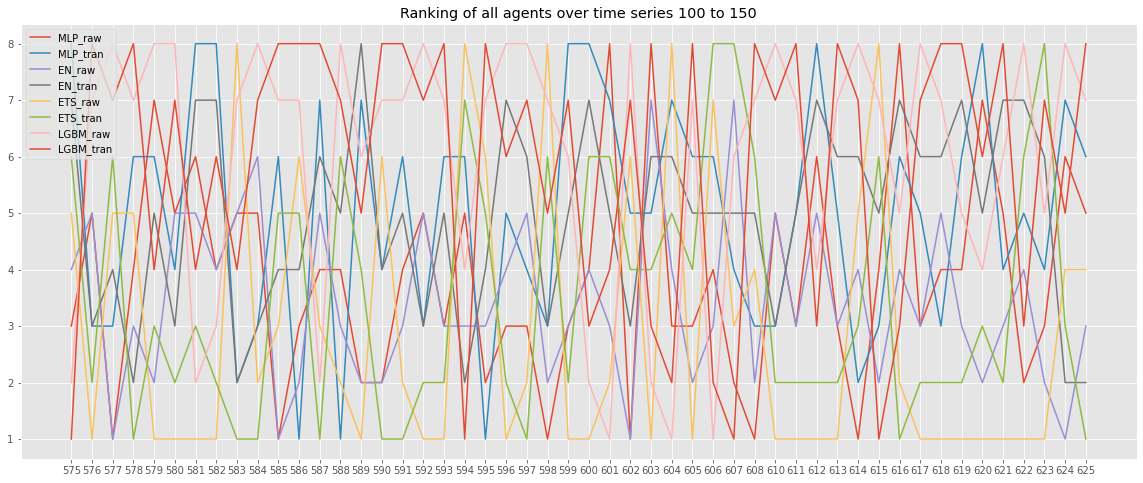

In [30]:
segment_start: int = 100
segment_end: int = 150

for agent, plays in agent_infos.items():
    plt.plot(series_ran[segment_start:segment_end], [play['ranking'] for play in list(plays.values())[segment_start:segment_end]], label=f'{agent}')

plt.title(f'Ranking of all agents over time series {segment_start} to {segment_end}')
plt.legend()
plt.show()

In [63]:
np.array(series_ran[segment_start:segment_end]).astype(float) + 0.1

array([575.1, 576.1, 577.1, 578.1, 579.1, 580.1, 581.1, 582.1, 583.1,
       584.1, 585.1, 586.1, 587.1, 588.1, 589.1, 590.1, 591.1, 592.1,
       593.1, 594.1, 595.1, 596.1, 597.1, 598.1, 599.1, 600.1, 601.1,
       602.1, 603.1, 604.1, 605.1, 606.1, 607.1, 608.1, 610.1, 611.1,
       612.1, 613.1, 614.1, 615.1, 616.1, 617.1, 618.1, 619.1, 620.1,
       621.1, 622.1, 623.1, 624.1, 625.1])

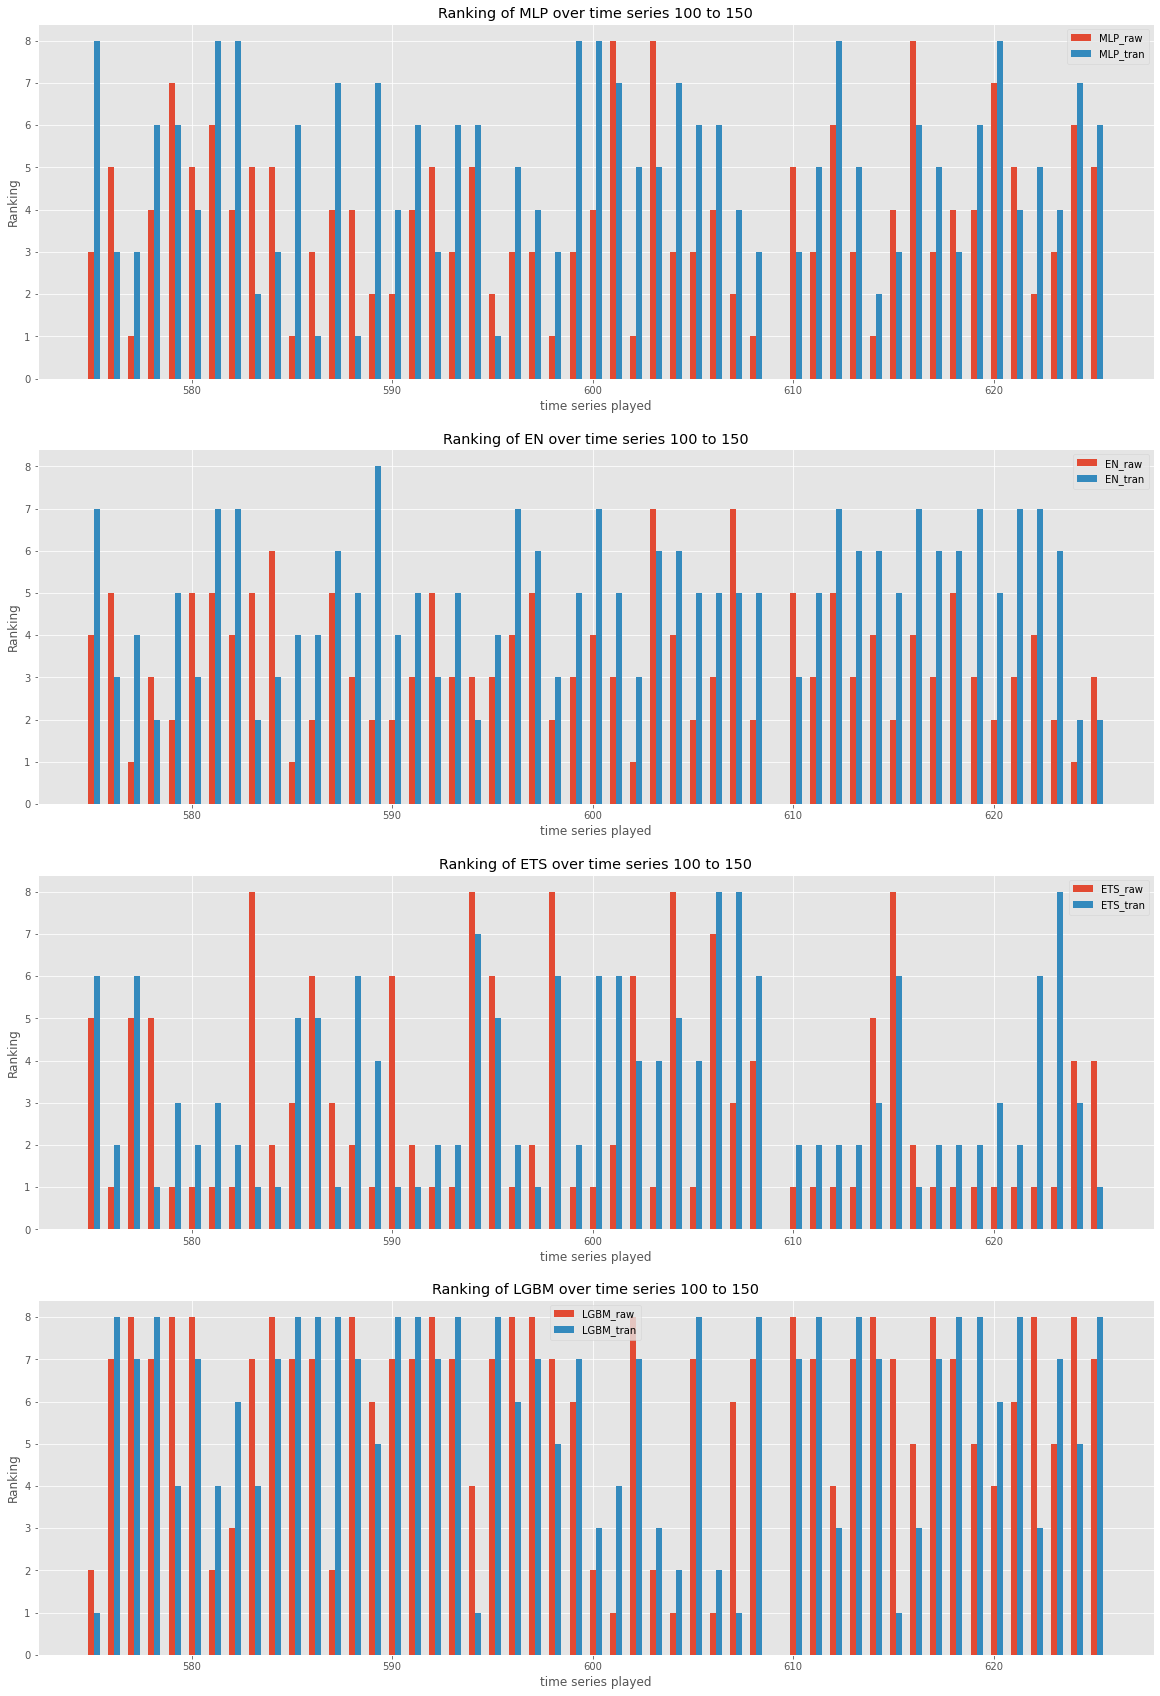

In [70]:
segment_start: int = 100
segment_end: int = 150
n_models = len(models)

fig, axs = plt.subplots(n_models, 1, sharey=True, figsize = (20, 30))
for i, m in enumerate(models):
    
    agent_1 = f'{m}_raw'
    agent_2 = f'{m}_tran'
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float),
        [
            play['ranking'] for play in list(agent_infos[agent_1].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_1
    )
    axs[i].bar(
        np.array(series_ran[segment_start:segment_end]).astype(float) + 0.3,
        [
            play['ranking'] for play in list(agent_infos[agent_2].values())[segment_start:segment_end]
        ],
        width=0.3,
        label=agent_2
    )
    axs[i].legend()
    axs[i].set_title(f'Ranking of {m} over time series {segment_start} to {segment_end}')
    axs[i].set_xlabel('time series played')
    axs[i].set_ylabel('Ranking')

plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In [73]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [74]:
alpha = 0.1
Q = len(list(agent_infos.keys()))
P = len(series_ran)
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,MLP_raw,MLP_tran,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran
mean SMAPE,0.079038,0.082179,0.077644,0.082397,0.063987,0.070303,0.087945,0.088874
std. SMAPE,0.062864,0.064296,0.062987,0.064115,0.058615,0.057552,0.066886,0.065641
mean ranking,4.166667,4.895238,3.880952,5.07619,2.557143,3.37619,5.585714,5.957143
std. ranking,1.819428,2.155497,1.567564,1.947869,2.227335,2.050878,2.272985,2.068602
90% ranking confi. limits,"(4.07992, 4.253413)","(4.808492, 4.981985)","(3.794206, 3.967699)","(4.989444, 5.162937)","(2.470396, 2.643889)","(3.289444, 3.462937)","(5.498968, 5.672461)","(5.870396, 6.043889)"


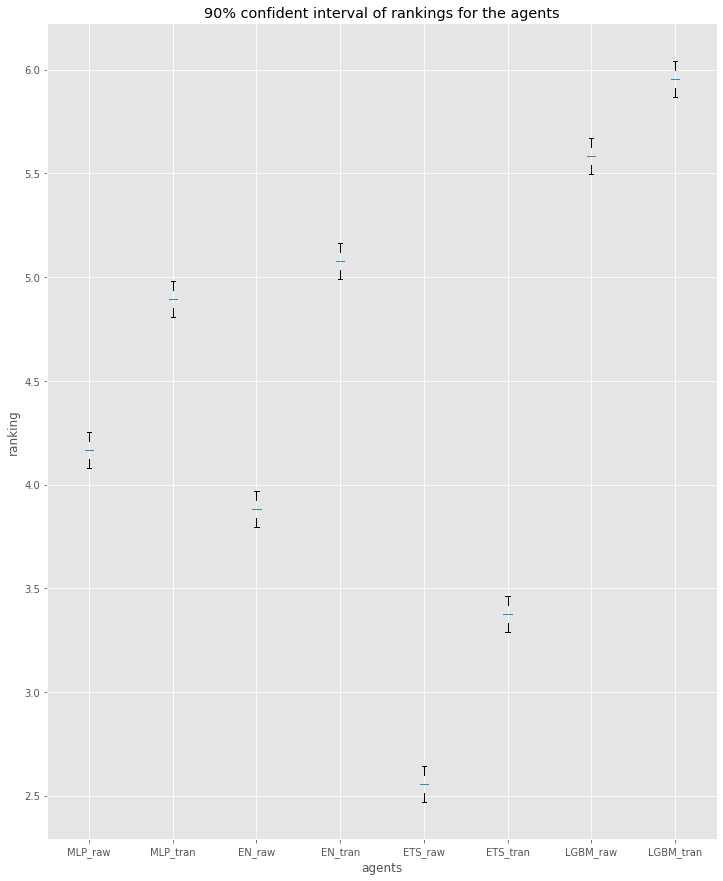

In [75]:
plt.figure(figsize=(12, 15))
plt.boxplot(
    [[agent[f'{100-int(alpha*100)}% ranking confi. limits'][0], agent['mean ranking'], agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]] for agent in stats.values()],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.1)
plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

In [76]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,MLP_raw,MLP_tran,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran
mean SMAPE,0.079038,0.082179,0.077644,0.082397,0.063987,0.070303,0.087945,0.088874
std. SMAPE,0.062864,0.064296,0.062987,0.064115,0.058615,0.057552,0.066886,0.065641
mean ranking,4.166667,4.895238,3.880952,5.07619,2.557143,3.37619,5.585714,5.957143
std. ranking,1.819428,2.155497,1.567564,1.947869,2.227335,2.050878,2.272985,2.068602
90% ranking confi. limits,"(4.07992, 4.253413)","(4.808492, 4.981985)","(3.794206, 3.967699)","(4.989444, 5.162937)","(2.470396, 2.643889)","(3.289444, 3.462937)","(5.498968, 5.672461)","(5.870396, 6.043889)"
frac best,0.07619,0.080952,0.052381,0.042857,0.533333,0.161905,0.047619,0.052381


: 

# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.